In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time

from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [20]:
ratings_path = "~/Downloads/ml-100k/u.data"
columns=["user_id", "movie_id", "rating", "timestamp"]
df = pd.read_csv(ratings_path, sep = '\t')

In [21]:
def train_stream_test_split(df):
    als_data = []
    stream_data = []
    for user_id in df["user_id"].unique():
        user_df = df[df["user_id"] == user_id].sort_values("timestamp")
        count = 0
        for row in user_df.itertuples():
            data = [row.user_id, row.movie_id, row.rating, row.timestamp]
            if count < len(user_df) / 2:
                als_data.append(data)
            else:
                stream_data.append(data)
            count += 1
    als_df = pd.DataFrame(data=als_data, columns=columns).sort_values("timestamp")
    movie_list = set(als_df['movie_id'])
    stream_df = pd.DataFrame(data=stream_data, columns=columns).sort_values("timestamp")
    # Drop movies not seen before from stream
    stream_df = stream_df.drop(stream_df[stream_df['movie_id'].map(lambda x: x not in movie_list)].index)
    test_df = stream_df.copy()
    return als_df, stream_df, test_df

In [22]:
als_df, stream_df, test_df = train_stream_test_split(df)

In [23]:
spark = SparkSession.builder.master('local').appName('als').getOrCreate()

In [24]:
spark_als_df = spark.createDataFrame(als_df) 
spark_stream_df = spark.createDataFrame(stream_df)

In [25]:
als = ALS(
         userCol="user_id", 
         itemCol="movie_id",
         ratingCol="rating", 
         nonnegative = True, 
         implicitPrefs = False,
         coldStartStrategy="drop",
         rank=150,
         maxIter=10,
         regParam=.1
)

In [26]:
model=als.fit(spark_als_df)

In [27]:
predictions = model.transform(spark_stream_df)
evaluator = RegressionEvaluator().setMetricName("rmse").setLabelCol("rating").setPredictionCol("prediction")
rmse = evaluator.evaluate(predictions)
rmse

1.0031863387882756

In [28]:
def get_als_features(model):
    
    user_features = dict()
    user_feature_df = model.userFactors.toPandas()
    for row in user_feature_df.itertuples():
        user_features[row.id] = np.array(row.features)
    
    movie_features = dict()
    movie_feature_df = model.itemFactors.toPandas()
    for row in movie_feature_df.itertuples():
        movie_features[row.id] = np.array(row.features)
    
    return user_features, movie_features

In [29]:
class ALSStreamingModel():
    
    def __init__(self, als_model, train_data, test_data, num_users, num_movies, learning_rate, user_feature_reg):
        self.als_model = als_model
        self.train_data = train_data
        self.test_data = test_data
        self.num_users = num_users + 1
        self.num_movies = num_movies + 1
        self.learning_rate = learning_rate
        self.num_features = self.als_model.rank
        
        # make movie vectors initialiazble, global bias = avg(rating)
        self.user_vectors, self.movie_vectors = get_als_features(self.als_model)
        self.user_feature_reg = user_feature_reg
        
    def train(self):
        mse = []
        als_mse = []
        count = 0
        for row in self.train_data.itertuples():
            curr = time.time()
            if count % 1000 == 0:
                mse.append(self.compute_test_mse())
                als_mse.append(self.compute_als_mse())
            user_id = row.user_id
            movie_id = row.movie_id
            rating = row.rating
            self.step(user_id, movie_id, rating)
            count += 1
        mse.append(self.compute_test_mse())
        als_mse.append(self.compute_als_mse())
        self.als_mse_record = als_mse
        self.test_mse_record = mse
            
    
    def update_features(self, user_id, movie_id, error):
        self.user_vectors[user_id] += self.learning_rate * (error * self.movie_vectors[movie_id] - self.user_feature_reg * self.user_vectors[user_id])
        
    def predict_rating(self, user_id, movie_id):
        prediction = self.user_vectors[user_id].dot(self.movie_vectors[movie_id].T)
        return prediction
    
    def compute_prediction_error(self, user_id, movie_id, rating):
        prediction = self.predict_rating(user_id, movie_id)
        return rating - prediction
    
    def step(self, user_id, movie_id, rating):
        error = self.compute_prediction_error(user_id, movie_id, rating)
        self.update_features(user_id, movie_id, error)
            
    def compute_test_mse(self):
        predictions = []
        ratings = []
        count = 0
        for row in self.test_data.itertuples():
            user_id = row.user_id
            movie_id = row.movie_id
            rating = row.rating
            predictions.append(self.predict_rating(user_id, movie_id))
            ratings.append(rating) 
        mse = mean_squared_error(ratings, predictions)
        return mse
    
    def compute_train_mse(self):
        predictions = []
        ratings = []
        for row in self.train_data.itertuples():
            user_id = row.user_id
            movie_id = row.movie_id
            rating = row.rating
            if movie_id in self.movie_vectors:
                predictions.append(self.predict_rating(user_id, movie_id))
                ratings.append(rating)
        mse = mean_squared_error(ratings, predictions)
        return mse
    
    def compute_als_mse(self):
        user_features, movie_features = get_als_features(self.als_model)
        ratings = []
        predictions = []
        for row in self.test_data.itertuples():
            user_id = row.user_id
            movie_id = row.movie_id
            rating = row.rating
            prediction = user_features[user_id].dot(movie_features[movie_id].T)
            predictions.append(prediction)
            ratings.append(rating)
        mse = mean_squared_error(ratings, predictions)
        return mse
    
    def plot_learning_curve(self):
        """visualize the training/testing loss"""
        linewidth = 3
        plt.plot(self.test_mse_record, label = 'ALS + Stream', linewidth = linewidth)
        plt.plot(self.als_mse_record, label = 'ALS', linewidth = linewidth)
        plt.xlabel('iterations')
        plt.ylabel('MSE')
        plt.legend(loc = 'best')

In [30]:
def generate_optimal_hyperparameters():
    learning_rates = [1e-3, 1e-2, 1e-1, 2e-1, 2e-2]
    user_bias_reg = [1e-2, 1e-1, 2e-1]
    movie_bias_reg = [1e-2, 1e-1, 2e-1]
    user_feature_reg = [1e-2, 1e-1, 2e-1, 2e-2]
    movie_feature_reg = [1e-2, 1e-1, 2e-1]

    best_params = {}
    best_params['learning_rate'] = None
    best_params['user_bias_reg'] = None
    best_params['movie_bias_reg'] = None
    best_params['user_feature_reg'] = None
    best_params['movie_feature_reg'] = None
    best_params['train_mse'] = np.inf
    best_params['test_mse'] = np.inf
    best_params['model'] = None


    for rate in learning_rates:
        print(rate)
        for ufreg in user_feature_reg:
            als_stream = ALSStreamingModel(model, stream_df, test_df, num_users, num_movies, rate, .1)
            als_stream.train()
            test_mse = als_stream.compute_test_mse()
            if test_mse < best_params['test_mse']:
                best_params['test_mse'] = test_mse
                best_params['learning_rate'] = rate
                best_params['user_feature_reg'] = ufreg
                best_params['model'] = als_stream
                print("New optimal parameters")
    return best_params

In [31]:
optimal_learning_rate = .02
optimal_uf_reg = .01
num_users = max(stream_df['user_id'])
num_movies = max(stream_df['movie_id'])
als_stream = ALSStreamingModel(model, stream_df, test_df, num_users, num_movies, optimal_learning_rate, optimal_uf_reg)

/opt/homebrew/Caskroom/miniconda/base/envs/myenv/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [32]:
als_stream.train()

/opt/homebrew/Caskroom/miniconda/base/envs/myenv/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/myenv/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/myenv/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/myenv/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/myenv/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreat

/opt/homebrew/Caskroom/miniconda/base/envs/myenv/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/myenv/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/myenv/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/myenv/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/myenv/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreat

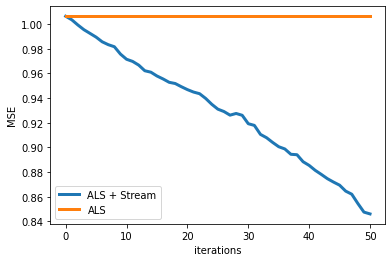

In [33]:
als_stream.plot_learning_curve()

In [34]:
als_stream.als_mse_record[-1], als_stream.test_mse_record[-1]

(1.006382838385683, 0.8460319320377083)